In [1]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from category_encoders.target_encoder import TargetEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (GridSearchCV,KFold, train_test_split)
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('amostra (1).csv')

In [4]:
df = df.drop(['Unnamed: 0'], axis=1)

In [5]:
df.head()

,cod_pedido,cidade_destinatario,uf,grp_transportadora,dt_despacho_pedido,hr_despacho_pedido,dt_entrega_pedido,hr_entrega_pedido,dt_previsao_entrega_cliente,dt_criacao,dt_pagamento_pedido,flg_existem_ocorrencias,tp_praca,des_unidade_negocio,des_cd_origem,qtd_dias_tat,tp_performance_entrega
0,127995108-1,CURITIBA,PR,Transportadora 4,2023-12-04,05:56:39,2023-12-07,12:19:04,2023-12-07,2023-11-30,2023-11-30,Não,Capital,Multi,PR-Campina G. Sul,5.0,Entregue no Prazo
1,126433711-1,PARAUAPEBAS,PA,Transportadora 2,2023-11-21,12:39:55,2023-12-01,12:23:47,2023-12-11,2023-11-15,2023-11-17,Não,Interior,Mono,PR-Campina G. Sul,10.0,Entregue no Prazo
2,125177091-1,JACAREZINHO,PR,Transportadora 4,2023-10-28,10:12:24,2023-10-31,16:10:01,2023-11-06,2023-10-26,2023-10-27,Não,Interior,Mono,PR-Campina G. Sul,2.0,Entregue no Prazo
3,123168303-1,SÃO PAULO,SP,Transportadora 5,2023-08-23,17:52:06,2023-08-24,12:00:13,2023-08-24,2023-08-22,2023-08-22,Não,Capital,Multi,PR-Campina G. Sul,2.0,Entregue no Prazo
4,122901808,SAO LUIS,MA,Transportadora 3,2023-08-14,08:41:00,2023-08-23,15:22:59,2023-08-24,2023-08-13,2023-08-12,não,Capital,Multi,PR-Campina G. Sul,8.0,Entregue no Prazo


In [6]:
from tabulate import tabulate
resumo_numerico = df.describe()
resumo_numerico = df.describe()

resumo_categorico = df.describe(include='object')
print("Resumo Estatístico para Variáveis Numéricas:")
print(tabulate(resumo_numerico, headers='keys', tablefmt='pretty'))

print("\nResumo Estatístico para Variáveis Categóricas:")
print(resumo_categorico)

Resumo Estatístico para Variáveis Numéricas:
+-------+--------------------+
|       |    qtd_dias_tat    |
+-------+--------------------+
| count |      467534.0      |
| mean  | 3.9165087458879997 |
|  std  |  2.98779096096958  |
|  min  |        0.0         |
|  25%  |        2.0         |
|  50%  |        3.0         |
|  75%  |        5.0         |
|  max  |       297.0        |
+-------+--------------------+

Resumo Estatístico para Variáveis Categóricas:
         cod_pedido cidade_destinatario      uf grp_transportadora  \
count        503532              503532  503532             503532   
unique       503532                9491      27                  8   
top     127995108-1           SÃO PAULO      SP   Transportadora 1   
freq              1               57204  180446             220375   

       dt_despacho_pedido hr_despacho_pedido dt_entrega_pedido  \
count              496767             496767            499069   
unique                190              82378        

In [7]:
df['flg_existem_ocorrencias'] = df['flg_existem_ocorrencias'].replace('Não', 0).replace('não', 0).replace('Sim', 1).replace('sim', 1)

In [8]:
df['tp_performance_entrega'] = df['tp_performance_entrega'].replace('Entregue no Prazo', 0).replace('Fora do Prazo', 1)

In [9]:
df['dt_criacao'] = pd.to_datetime(df['dt_criacao'])
df['dt_pagamento_pedido'] = pd.to_datetime(df['dt_pagamento_pedido'])
df['intervalo_pedido_pagamento'] = (df['dt_pagamento_pedido'] - df['dt_criacao']).dt.days

In [10]:
df['dt_entrega_pedido'] = pd.to_datetime(df['dt_entrega_pedido'])
df['dt_previsao_entrega_cliente'] = pd.to_datetime(df['dt_previsao_entrega_cliente'])
df['intervalo_previsto_entregue'] = (df['dt_entrega_pedido'] - df['dt_previsao_entrega_cliente']).dt.days

In [11]:
df['intervalo_entrega'] = (df['dt_entrega_pedido'] - df['dt_criacao']).dt.days

In [12]:
df['mes_pedido'] = df['dt_criacao'].dt.month

In [13]:
def adiantou_ou_atrasou(intervalo):
    if intervalo < 0:
        return 2  # Atrasado
    if intervalo > 0:
        return 0
    else:
        return 1

In [14]:
df['status'] = df['intervalo_previsto_entregue'].apply(adiantou_ou_atrasou)

In [15]:
df['uf_origem'] = df['des_cd_origem'].str.split('-').str[0]

In [16]:
df = df[df['intervalo_previsto_entregue'].notnull()] 
df = df[df['intervalo_pedido_pagamento'].notnull()] 

In [17]:
df.columns

Index(['cod_pedido', 'cidade_destinatario', 'uf', 'grp_transportadora',
       'dt_despacho_pedido', 'hr_despacho_pedido', 'dt_entrega_pedido',
       'hr_entrega_pedido', 'dt_previsao_entrega_cliente', 'dt_criacao',
       'dt_pagamento_pedido', 'flg_existem_ocorrencias', 'tp_praca',
       'des_unidade_negocio', 'des_cd_origem', 'qtd_dias_tat',
       'tp_performance_entrega', 'intervalo_pedido_pagamento',
       'intervalo_previsto_entregue', 'intervalo_entrega', 'mes_pedido',
       'status', 'uf_origem'],
      dtype='object')

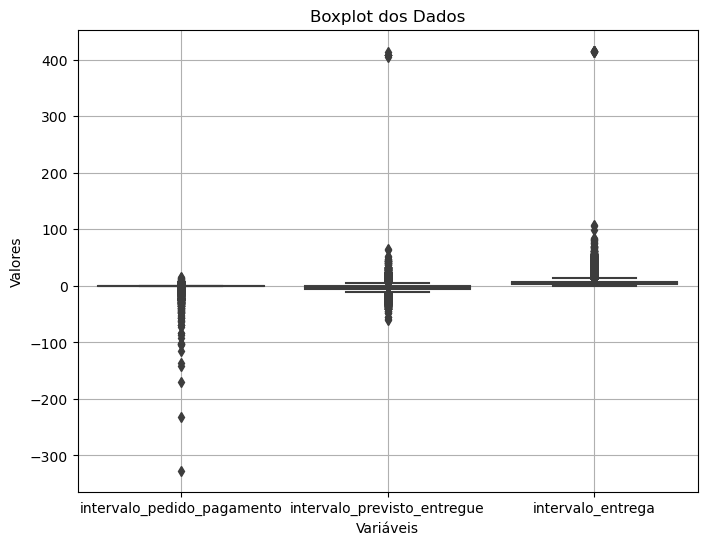

In [18]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df[['intervalo_pedido_pagamento', 'intervalo_previsto_entregue', 'intervalo_entrega']])
plt.title('Boxplot dos Dados')
plt.xlabel('Variáveis')
plt.ylabel('Valores')
plt.grid(True)
plt.show()

In [19]:
def remove_outliers_df(df):
    for coluna in df.columns:
        df[coluna] = df[coluna][(df[coluna] <= 400)]
        df[coluna] = df[coluna][(df[coluna] >= -100)]
    return df

colunas_para_remover_outliers = ['intervalo_pedido_pagamento', 'intervalo_previsto_entregue', 'intervalo_entrega']
df[colunas_para_remover_outliers] = remove_outliers_df(df[colunas_para_remover_outliers])

In [20]:
df

,cod_pedido,cidade_destinatario,uf,grp_transportadora,dt_despacho_pedido,hr_despacho_pedido,dt_entrega_pedido,hr_entrega_pedido,dt_previsao_entrega_cliente,dt_criacao,...,des_unidade_negocio,des_cd_origem,qtd_dias_tat,tp_performance_entrega,intervalo_pedido_pagamento,intervalo_previsto_entregue,intervalo_entrega,mes_pedido,status,uf_origem
0,127995108-1,CURITIBA,PR,Transportadora 4,2023-12-04,05:56:39,2023-12-07,12:19:04,2023-12-07,2023-11-30,...,Multi,PR-Campina G. Sul,5.0,0,0.0,0.0,7.0,11,1,PR
1,126433711-1,PARAUAPEBAS,PA,Transportadora 2,2023-11-21,12:39:55,2023-12-01,12:23:47,2023-12-11,2023-11-15,...,Mono,PR-Campina G. Sul,10.0,0,2.0,-10.0,16.0,11,2,PR
2,125177091-1,JACAREZINHO,PR,Transportadora 4,2023-10-28,10:12:24,2023-10-31,16:10:01,2023-11-06,2023-10-26,...,Mono,PR-Campina G. Sul,2.0,0,1.0,-6.0,5.0,10,2,PR
3,123168303-1,SÃO PAULO,SP,Transportadora 5,2023-08-23,17:52:06,2023-08-24,12:00:13,2023-08-24,2023-08-22,...,Multi,PR-Campina G. Sul,2.0,0,0.0,0.0,2.0,8,1,PR
4,122901808,SAO LUIS,MA,Transportadora 3,2023-08-14,08:41:00,2023-08-23,15:22:59,2023-08-24,2023-08-13,...,Multi,PR-Campina G. Sul,8.0,0,-1.0,-1.0,10.0,8,2,PR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503525,123180072-1,SÃO PAULO,SP,Transportadora 5,2023-08-23,17:39:03,2023-08-26,12:30:53,2023-08-24,2023-08-22,...,Multi,PR-Campina G. Sul,3.0,1,0.0,2.0,4.0,8,0,PR
503526,123882649-1,São Paulo,SP,Transportadora 1,2023-09-19,15:09:15,2023-09-25,14:03:59,2023-09-20,2023-09-18,...,Multi,SP-Jaguaré,6.0,1,-2.0,5.0,7.0,9,0,SP
503527,124807656-1,NITERÓI,RJ,Transportadora 3,2023-10-16,14:59:28,2023-10-19,14:56:27,2023-10-18,2023-10-14,...,Mono,SP-Registro,4.0,1,0.0,1.0,5.0,10,0,SP
503529,121957602-1,Canoas,RS,Transportadora 4,2023-07-11,03:14:47,2023-07-13,18:16:59,2023-07-12,2023-07-11,...,Multi,PR-Campina G. Sul,4.0,1,-2.0,1.0,2.0,7,0,PR


In [21]:
status_medio_trecho_transp = df.groupby(['grp_transportadora'])['status'].mean().reset_index(name='status_medio')

viagens_por_rota_transp = df.groupby(['uf_origem', 'uf', 'grp_transportadora']).size().reset_index(name='viagens')

status_rota_transp = df.groupby(['uf_origem', 'uf', 'grp_transportadora'])['status'].mean().reset_index(name='status_rota_transp')

viagens_atrasadas_rota_transp = df.groupby(['uf_origem', 'uf', 'grp_transportadora'])['tp_performance_entrega'].sum().reset_index(name='viagens_atrasadas_rota_transp')

df_merge = pd.merge(viagens_por_rota_transp, viagens_atrasadas_rota_transp, on=['uf_origem', 'uf', 'grp_transportadora'])

df_merge = pd.merge(df_merge, status_rota_transp, on=['uf_origem', 'uf', 'grp_transportadora'])

In [22]:
df_merge['percentual_atraso'] = df_merge.viagens_atrasadas_rota_transp / df_merge.viagens

In [23]:
total_por_trecho = df_merge.groupby(['grp_transportadora'])['viagens'].sum().reset_index(name='total_viagens_transp')

df_merge = pd.merge(df_merge, total_por_trecho, on=['grp_transportadora'])

df_merge['percentual_viagens_rota'] = df_merge.viagens / df_merge.total_viagens_transp

In [24]:
indice_transp_trecho = df.groupby(['grp_transportadora'])['status'].mean().reset_index(name='status_transportadora')

In [25]:
df_merge = pd.merge(df_merge, indice_transp_trecho, on=['grp_transportadora'])

In [26]:
df_merge

,uf_origem,uf,grp_transportadora,viagens,viagens_atrasadas_rota_transp,status_rota_transp,percentual_atraso,total_viagens_transp,percentual_viagens_rota,status_transportadora
0,PR,AC,Transportadora 1,79,21,1.316456,0.265823,199098,0.000397,1.915876
1,PR,AL,Transportadora 1,1491,18,1.963783,0.012072,199098,0.007489,1.915876
2,PR,AM,Transportadora 1,7,0,2.000000,0.000000,199098,0.000035,1.915876
3,PR,BA,Transportadora 1,3244,54,1.948829,0.016646,199098,0.016293,1.915876
4,PR,CE,Transportadora 1,1296,9,1.981481,0.006944,199098,0.006509,1.915876
...,...,...,...,...,...,...,...,...,...,...
220,PR,PR,Transportadora 6,1093,89,1.399817,0.081427,1093,1.000000,1.399817
221,PR,SP,Transportadora 5,16391,1782,1.353182,0.108718,22129,0.740702,1.365177
222,SP,SP,Transportadora 5,5738,1086,1.399442,0.189265,22129,0.259298,1.365177
223,SP,RJ,Transportadora 8,41,3,1.731707,0.073171,619,0.066236,1.827141


In [27]:
df_merge.to_csv('grp_transportadora.csv', index=False)

In [28]:
idx = df_merge.groupby('grp_transportadora')['percentual_viagens_rota'].idxmax()
df_max_percent_viagens = df_merge.loc[idx]

df_max_percent_viagens = df_max_percent_viagens[['grp_transportadora', 'uf_origem', 'uf', 'percentual_atraso', 'percentual_viagens_rota']]

print(df_max_percent_viagens)

    grp_transportadora uf_origem  uf  percentual_atraso  \
22    Transportadora 1        PR  SP           0.011479   
66    Transportadora 2        PR  RJ           0.071723   
152   Transportadora 3        SP  SP           0.025874   
213   Transportadora 4        PR  RS           0.048275   
221   Transportadora 5        PR  SP           0.108718   
220   Transportadora 6        PR  PR           0.081427   
159   Transportadora 7        PR  CE           0.003390   
224   Transportadora 8        SP  SP           0.044983   

     percentual_viagens_rota  
22                  0.282655  
66                  0.142912  
152                 0.273221  
213                 0.286453  
221                 0.740702  
220                 1.000000  
159                 0.122865  
224                 0.933764  


In [29]:
df_max_percent_viagens['trecho'] = df_max_percent_viagens.uf_origem + '-' + df_max_percent_viagens.uf + '(' + df_max_percent_viagens.grp_transportadora + ')'

In [30]:
df_max_percent_viagens

,grp_transportadora,uf_origem,uf,percentual_atraso,percentual_viagens_rota,trecho
22,Transportadora 1,PR,SP,0.011479,0.282655,PR-SP(Transportadora 1)
66,Transportadora 2,PR,RJ,0.071723,0.142912,PR-RJ(Transportadora 2)
152,Transportadora 3,SP,SP,0.025874,0.273221,SP-SP(Transportadora 3)
213,Transportadora 4,PR,RS,0.048275,0.286453,PR-RS(Transportadora 4)
221,Transportadora 5,PR,SP,0.108718,0.740702,PR-SP(Transportadora 5)
220,Transportadora 6,PR,PR,0.081427,1.000000,PR-PR(Transportadora 6)
159,Transportadora 7,PR,CE,0.003390,0.122865,PR-CE(Transportadora 7)
224,Transportadora 8,SP,SP,0.044983,0.933764,SP-SP(Transportadora 8)


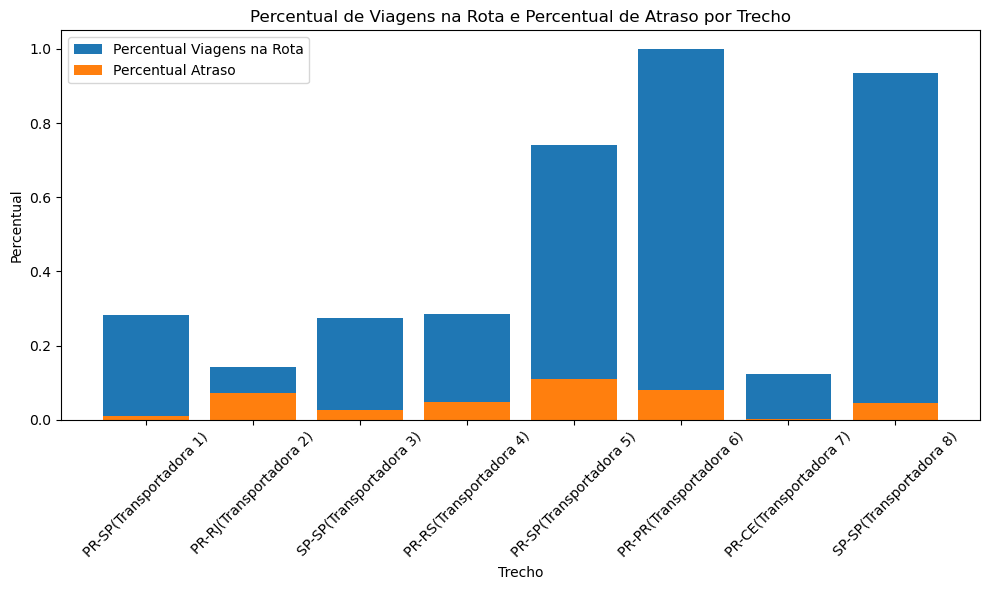

In [31]:
plt.figure(figsize=(10, 6))
plt.bar(df_max_percent_viagens.trecho,df_max_percent_viagens.percentual_viagens_rota, label='Percentual Viagens na Rota')
plt.bar(df_max_percent_viagens.trecho, df_max_percent_viagens.percentual_atraso,  label='Percentual Atraso')

plt.xlabel('Trecho')
plt.ylabel('Percentual')
plt.title('Percentual de Viagens na Rota e Percentual de Atraso por Trecho')
plt.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [32]:
viagens_por_mes_indice_atrsos = df.groupby(['mes_pedido'])['intervalo_previsto_entregue'].mean().reset_index()

In [33]:
viagens_por_mes_indice_atrsos.columns = ['mes_pedido', 'indice_mes']

In [34]:
df = pd.merge(df, viagens_por_mes_indice_atrsos, on=['mes_pedido'])

In [35]:
df.head()

,cod_pedido,cidade_destinatario,uf,grp_transportadora,dt_despacho_pedido,hr_despacho_pedido,dt_entrega_pedido,hr_entrega_pedido,dt_previsao_entrega_cliente,dt_criacao,...,des_cd_origem,qtd_dias_tat,tp_performance_entrega,intervalo_pedido_pagamento,intervalo_previsto_entregue,intervalo_entrega,mes_pedido,status,uf_origem,indice_mes
0,127995108-1,CURITIBA,PR,Transportadora 4,2023-12-04,05:56:39,2023-12-07,12:19:04,2023-12-07,2023-11-30,...,PR-Campina G. Sul,5.0,0,0.0,0.0,7.0,11,1,PR,-4.102798
1,126433711-1,PARAUAPEBAS,PA,Transportadora 2,2023-11-21,12:39:55,2023-12-01,12:23:47,2023-12-11,2023-11-15,...,PR-Campina G. Sul,10.0,0,2.0,-10.0,16.0,11,2,PR,-4.102798
2,127416977-2,SÃO PAULO,SP,Transportadora 1,2023-11-26,02:14:59,2023-11-28,16:09:02,2023-12-06,2023-11-24,...,PR-Campina G. Sul,2.0,0,0.0,-8.0,4.0,11,2,PR,-4.102798
3,125952478-3,SANTO ANDRÉ,SP,Transportadora 1,2023-11-11,12:38:50,2023-11-15,08:03:11,2023-11-16,2023-11-11,...,PR-Campina G. Sul,2.0,0,0.0,-1.0,4.0,11,2,PR,-4.102798
4,127591626,GOIÂNIA,GO,Transportadora 3,2023-11-28,21:45:28,2023-12-02,17:40:18,2023-12-08,2023-11-25,...,PR-Campina G. Sul,5.0,0,0.0,-6.0,7.0,11,2,PR,-4.102798


In [36]:
final = pd.merge(df, df_merge, on=['grp_transportadora', 'uf', 'uf_origem'])

In [37]:
final.columns

Index(['cod_pedido', 'cidade_destinatario', 'uf', 'grp_transportadora',
       'dt_despacho_pedido', 'hr_despacho_pedido', 'dt_entrega_pedido',
       'hr_entrega_pedido', 'dt_previsao_entrega_cliente', 'dt_criacao',
       'dt_pagamento_pedido', 'flg_existem_ocorrencias', 'tp_praca',
       'des_unidade_negocio', 'des_cd_origem', 'qtd_dias_tat',
       'tp_performance_entrega', 'intervalo_pedido_pagamento',
       'intervalo_previsto_entregue', 'intervalo_entrega', 'mes_pedido',
       'status', 'uf_origem', 'indice_mes', 'viagens',
       'viagens_atrasadas_rota_transp', 'status_rota_transp',
       'percentual_atraso', 'total_viagens_transp', 'percentual_viagens_rota',
       'status_transportadora'],
      dtype='object')

In [38]:
media = final.groupby(['uf_origem', 'uf', 'mes_pedido'])['intervalo_previsto_entregue'].mean().reset_index(name='media_atraso')

In [39]:
idx = df.groupby('mes_pedido')['intervalo_previsto_entregue'].idxmax()

df_max_percent_viagens = df.loc[idx]

merge = pd.merge(df_max_percent_viagens, media, on=['uf_origem', 'uf', 'mes_pedido'])

merge = merge[['mes_pedido', 'uf_origem', 'uf', 'intervalo_previsto_entregue', 'media_atraso']]

print(merge)

   mes_pedido uf_origem  uf  intervalo_previsto_entregue  media_atraso
0           6        SP  SP                          7.0     -2.720000
1           7        PR  DF                         65.0     -0.744799
2           8        PR  SP                         50.0     -1.933333
3           9        PR  PI                         38.0     -9.050725
4          10        SP  SP                         42.0     -3.304440
5          11        SP  RJ                         53.0     -3.482158
6          12        PR  PR                         39.0     -2.165698


In [40]:
merge['trecho'] = merge.uf_origem.astype(str) + '-' + merge.uf.astype(str) + '(' + merge.mes_pedido.astype(str) + ')'


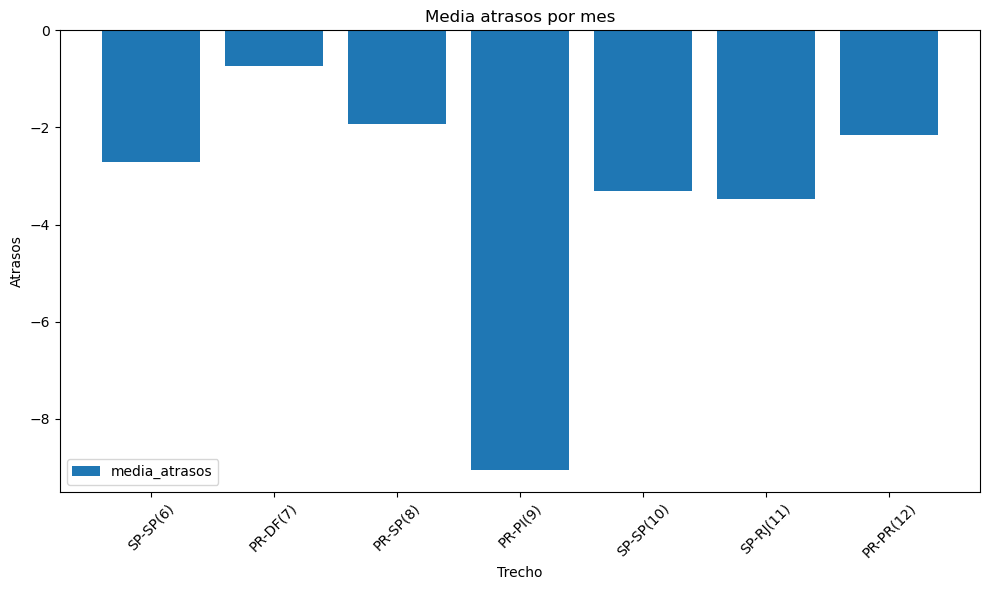

In [41]:
plt.figure(figsize=(10, 6))
plt.bar(merge.trecho,merge.media_atraso, label='media_atrasos')


plt.xlabel('Trecho')
plt.ylabel('Atrasos')
plt.title('Media atrasos por mes')
plt.legend()


plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [42]:
viagens_por_mes = df.groupby(['mes_pedido']).size().reset_index(name='viagens')

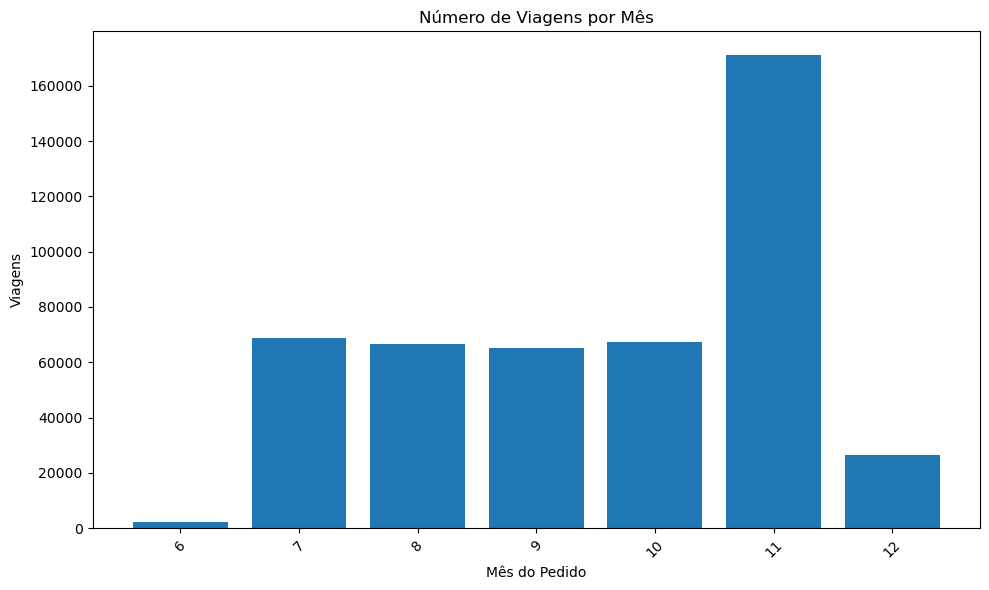

In [43]:
plt.figure(figsize=(10, 6)) 

plt.bar(viagens_por_mes.mes_pedido, viagens_por_mes.viagens) 
plt.xlabel('Mês do Pedido')  
plt.ylabel('Viagens') 
plt.title('Número de Viagens por Mês')  
plt.xticks(rotation=45)  
plt.tight_layout()  

plt.show()  

In [44]:
idx = df.groupby('mes_pedido')['intervalo_previsto_entregue'].idxmax()
df_max_percent_viagens = df.loc[idx]

df_max_percent_viagens = df_max_percent_viagens[['mes_pedido', 'uf_origem', 'uf', 'intervalo_previsto_entregue']]

print(df_max_percent_viagens)

        mes_pedido uf_origem  uf  intervalo_previsto_entregue
440987           6        SP  SP                          7.0
437141           7        PR  DF                         65.0
303346           8        PR  SP                         50.0
368825           9        PR  PI                         38.0
237188          10        SP  SP                         42.0
163822          11        SP  RJ                         53.0
467343          12        PR  PR                         39.0


In [45]:
df_max_percent_viagens['trecho'] = df_max_percent_viagens.uf_origem.astype(str) + '-' + df_max_percent_viagens.uf.astype(str) + '(' + df_max_percent_viagens.mes_pedido.astype(str) + ')'

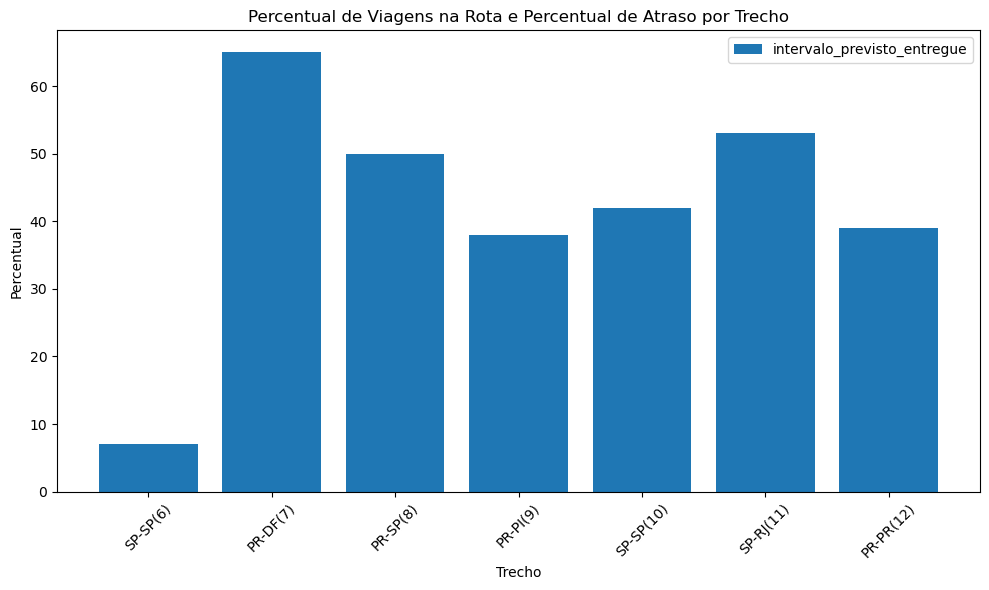

In [46]:
plt.figure(figsize=(10, 6))
plt.bar(df_max_percent_viagens.trecho,df_max_percent_viagens.intervalo_previsto_entregue, label='intervalo_previsto_entregue')

plt.xlabel('Trecho')
plt.ylabel('Percentual')
plt.title('Percentual de Viagens na Rota e Percentual de Atraso por Trecho')
plt.legend()


plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [47]:
viagens_por_mes_indice_atrsos = df.groupby(['mes_pedido'])['intervalo_previsto_entregue'].mean().reset_index()

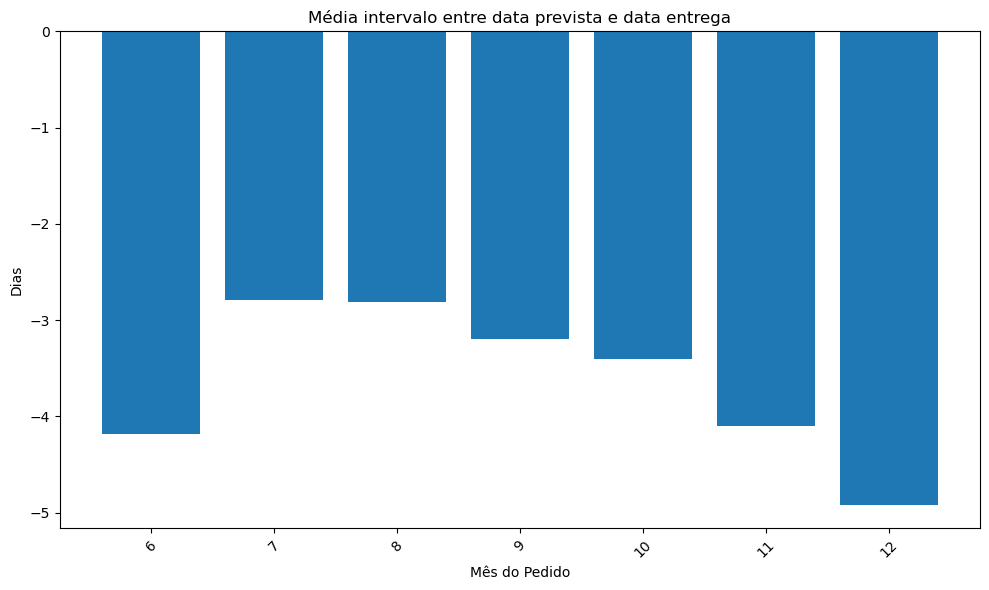

In [48]:
plt.figure(figsize=(10, 6))  

plt.bar(viagens_por_mes_indice_atrsos.mes_pedido, viagens_por_mes_indice_atrsos.intervalo_previsto_entregue)  
plt.xlabel('Mês do Pedido') 
plt.ylabel('Dias') 
plt.title('Média intervalo entre data prevista e data entrega') 
plt.xticks(rotation=45)  
plt.tight_layout() 

plt.show()  

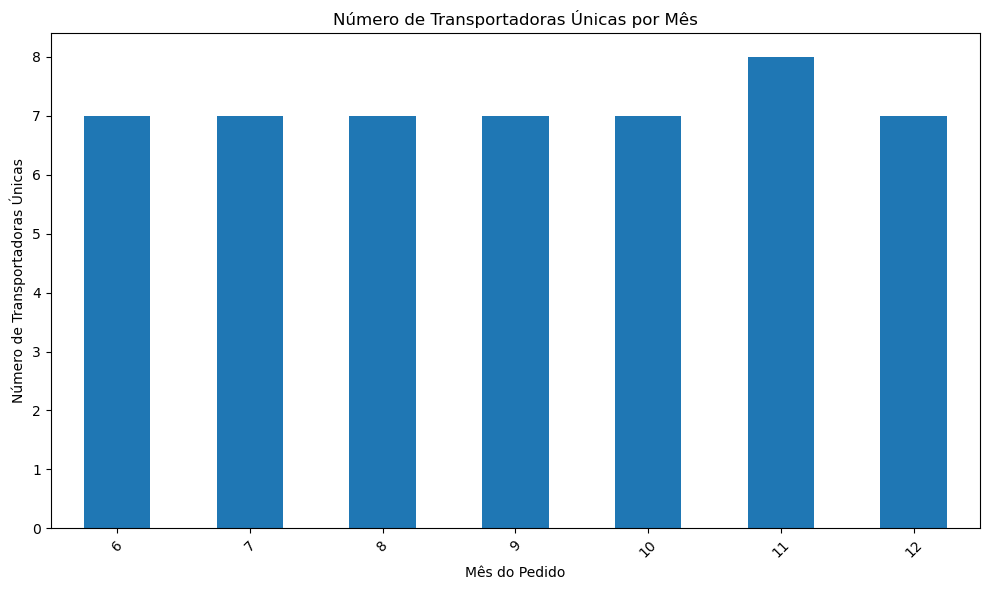

In [49]:
unique_values_per_month = df.groupby('mes_pedido')['grp_transportadora'].nunique()


plt.figure(figsize=(10, 6)) 

unique_values_per_month.plot(kind='bar') 
plt.xlabel('Mês do Pedido')
plt.ylabel('Número de Transportadoras Únicas') 
plt.title('Número de Transportadoras Únicas por Mês')  
plt.xticks(rotation=45)  
plt.tight_layout()  

plt.show() 

In [50]:
viagens_por_rota = df.groupby(['uf_origem', 'uf']).size().reset_index(name='viagens')

In [51]:
viagens_rota_bins = pd.cut(viagens_por_rota['viagens'], bins=3, labels=['Baixo', 'Médio', 'Alto'])
viagens_por_rota['viagens_rota_bins'] = viagens_rota_bins

In [52]:
x = viagens_por_rota[(viagens_por_rota['viagens_rota_bins'] == "Baixo")]
valor_maximo = x['viagens'].max()
valor_minimo = x['viagens'].min()

print(f"Valor Máximo: {valor_maximo}")
print(f"Valor Mínimo: {valor_minimo}")

x = viagens_por_rota[(viagens_por_rota['viagens_rota_bins'] == "Médio")]
valor_maximo = x['viagens'].max()
valor_minimo = x['viagens'].min()

print(f"Valor Máximo: {valor_maximo}")
print(f"Valor Mínimo: {valor_minimo}")

x = viagens_por_rota[(viagens_por_rota['viagens_rota_bins'] == "Alto")]
valor_maximo = x['viagens'].max()
valor_minimo = x['viagens'].min()

print(f"Valor Máximo: {valor_maximo}")
print(f"Valor Mínimo: {valor_minimo}")

Valor Máximo: 24899
Valor Mínimo: 72
Valor Máximo: 41951
Valor Mínimo: 31637
Valor Máximo: 87717
Valor Mínimo: 79188


In [53]:
import pandas as pd
import folium

# Dicionário com as coordenadas de alguns estados (latitude, longitude)
coordenadas_estados = {
    'AC': (-8.77, -70.55),
    'AL': (-9.71, -35.73),
    'AP': (1.41, -51.77),
    'AM': (-3.07, -61.66),
    'BA': (-12.96, -38.51),
    'CE': (-3.71, -38.54),
    'DF': (-15.83, -47.86),
    'ES': (-19.19, -40.34),
    'GO': (-16.64, -49.31),
    'MA': (-2.55, -44.30),
    'MT': (-12.64, -55.42),
    'MS': (-20.51, -54.54),
    'MG': (-18.10, -44.38),
    'PA': (-5.53, -52.29),
    'PB': (-7.06, -35.55),
    'PR': (-24.89, -51.55),
    'PE': (-8.28, -35.07),
    'PI': (-8.28, -43.68),
    'RJ': (-22.84, -43.15),
    'RN': (-5.22, -36.52),
    'RS': (-30.01, -51.22),
    'RO': (-11.22, -62.80),
    'RR': (1.89, -61.22),
    'SC': (-27.33, -49.44),
    'SP': (-23.55, -46.64),
    'SE': (-10.90, -37.07),
    'TO': (-10.25, -48.25)
}


In [54]:
def cor_por_intensidade(viagens):
    if viagens <= 24899:
        return ''
    elif viagens <= 41951 & viagens >= 31637:
        return 'blue'
    elif viagens >= 79188:
        return 'red'

def cor_por_intensidade_green(viagens):
    if viagens <= 24899:
        return 'green'
    else:
        return ''

In [55]:
mapa = folium.Map(location=[-15.77972, -47.92972], zoom_start=4)

In [56]:
for index, row in viagens_por_rota.iterrows():
    origem = coordenadas_estados[row['uf_origem']]
    destino = coordenadas_estados[row['uf']]
    folium.PolyLine(
        locations=[origem, destino],
        color=cor_por_intensidade(row['viagens']),
        weight=5,  
        opacity=0.9
    ).add_to(mapa)

In [57]:
for index, row in viagens_por_rota.iterrows():
    origem = coordenadas_estados[row['uf_origem']]
    destino = coordenadas_estados[row['uf']]
    folium.PolyLine(
        locations=[origem, destino],
        color=cor_por_intensidade_green(row['viagens']),
        weight=5, 
        opacity=0.3
    ).add_to(mapa)

In [58]:
mapa

In [59]:
viagens_atrasadas_rota = df.groupby(['uf_origem', 'uf'])['tp_performance_entrega'].sum().reset_index()
viagens_atrasadas_bins = pd.cut(viagens_atrasadas_rota['tp_performance_entrega'], bins=3, labels=['Baixo', 'Médio', 'Alto'])
viagens_atrasadas_rota['viagens_atrasadas_bins'] = viagens_atrasadas_bins

x = viagens_atrasadas_rota[(viagens_atrasadas_rota['viagens_atrasadas_bins'] == "Baixo")]
valor_maximo = x['tp_performance_entrega'].max()
valor_minimo = x['tp_performance_entrega'].min()

print(f"Valor Máximo: {valor_maximo}")
print(f"Valor Mínimo: {valor_minimo}")

x = viagens_atrasadas_rota[(viagens_atrasadas_rota['viagens_atrasadas_bins'] == "Médio")]
valor_maximo = x['tp_performance_entrega'].max()
valor_minimo = x['tp_performance_entrega'].min()

print(f"Valor Máximo: {valor_maximo}")
print(f"Valor Mínimo: {valor_minimo}")

x = viagens_atrasadas_rota[(viagens_atrasadas_rota['viagens_atrasadas_bins'] == "Alto")]
valor_maximo = x['tp_performance_entrega'].max()
valor_minimo = x['tp_performance_entrega'].min()

print(f"Valor Máximo: {valor_maximo}")
print(f"Valor Mínimo: {valor_minimo}")

Valor Máximo: 645
Valor Mínimo: 2
Valor Máximo: 1713
Valor Mínimo: 1139
Valor Máximo: 2986
Valor Mínimo: 2599


In [60]:
def cor_por_intensidade_green(viagens):
    if viagens <= 645:
        return 'green'
    elif viagens <= 1713 & viagens >= 1139:
        return ''
    elif viagens >= 2599:
        return ''

def cor_por_intensidade(viagens):
    if viagens <= 645:
        return ''
    elif viagens <= 1713 & viagens >= 1139:
        return 'blue'
    elif viagens >= 2599:
        return 'red'
    
mapa = folium.Map(location=[-15.77972, -47.92972], zoom_start=4)
for index, row in viagens_atrasadas_rota.iterrows():
    origem = coordenadas_estados[row['uf_origem']]
    destino = coordenadas_estados[row['uf']]
    folium.PolyLine(
        locations=[origem, destino],
        color=cor_por_intensidade(row['tp_performance_entrega']),
        weight=5,  
        opacity=0.9
    ).add_to(mapa)
mapa

for index, row in viagens_atrasadas_rota.iterrows():
    origem = coordenadas_estados[row['uf_origem']]
    destino = coordenadas_estados[row['uf']]
    folium.PolyLine(
        locations=[origem, destino],
        color=cor_por_intensidade_green(row['tp_performance_entrega']),
        weight=5,  
        opacity=0.3
    ).add_to(mapa)
mapa

In [61]:
df

,cod_pedido,cidade_destinatario,uf,grp_transportadora,dt_despacho_pedido,hr_despacho_pedido,dt_entrega_pedido,hr_entrega_pedido,dt_previsao_entrega_cliente,dt_criacao,...,des_cd_origem,qtd_dias_tat,tp_performance_entrega,intervalo_pedido_pagamento,intervalo_previsto_entregue,intervalo_entrega,mes_pedido,status,uf_origem,indice_mes
0,127995108-1,CURITIBA,PR,Transportadora 4,2023-12-04,05:56:39,2023-12-07,12:19:04,2023-12-07,2023-11-30,...,PR-Campina G. Sul,5.0,0,0.0,0.0,7.0,11,1,PR,-4.102798
1,126433711-1,PARAUAPEBAS,PA,Transportadora 2,2023-11-21,12:39:55,2023-12-01,12:23:47,2023-12-11,2023-11-15,...,PR-Campina G. Sul,10.0,0,2.0,-10.0,16.0,11,2,PR,-4.102798
2,127416977-2,SÃO PAULO,SP,Transportadora 1,2023-11-26,02:14:59,2023-11-28,16:09:02,2023-12-06,2023-11-24,...,PR-Campina G. Sul,2.0,0,0.0,-8.0,4.0,11,2,PR,-4.102798
3,125952478-3,SANTO ANDRÉ,SP,Transportadora 1,2023-11-11,12:38:50,2023-11-15,08:03:11,2023-11-16,2023-11-11,...,PR-Campina G. Sul,2.0,0,0.0,-1.0,4.0,11,2,PR,-4.102798
4,127591626,GOIÂNIA,GO,Transportadora 3,2023-11-28,21:45:28,2023-12-02,17:40:18,2023-12-08,2023-11-25,...,PR-Campina G. Sul,5.0,0,0.0,-6.0,7.0,11,2,PR,-4.102798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467529,128095373-1,CAXIAS DO SUL,RS,Transportadora 4,2023-12-04,13:39:44,2023-12-09,19:28:41,2023-12-08,2023-12-03,...,PR-Campina G. Sul,5.0,1,0.0,1.0,6.0,12,0,PR,-4.916387
467530,128062266-2,SÃO LUÍS,MA,Transportadora 3,2023-12-05,15:02:10,2023-12-20,08:47:41,2023-12-19,2023-12-02,...,PR-Campina G. Sul,13.0,1,0.0,1.0,18.0,12,0,PR,-4.916387
467531,128248367-1,CURITIBA,PR,Transportadora 4,2023-12-08,08:58:10,2023-12-14,14:20:43,2023-12-13,2023-12-07,...,PR-Campina G. Sul,5.0,1,0.0,1.0,7.0,12,0,PR,-4.916387
467532,128181694-1,TEÓFILO OTONI,MG,Transportadora 1,2023-12-06,13:28:41,2023-12-18,17:42:09,2023-12-14,2023-12-05,...,PR-Campina G. Sul,9.0,1,0.0,4.0,13.0,12,0,PR,-4.916387


In [62]:
viagens_atrasadas_rota_p = df.groupby(['uf_origem', 'uf'])['cod_pedido'].size().reset_index(name='total')
viagens_atrasadas_rota_p['atrasadas'] = df.groupby(['uf_origem', 'uf'])['tp_performance_entrega'].sum().reset_index(name='atrasadas').atrasadas
viagens_atrasadas_rota_p['atrasadas_per'] = viagens_atrasadas_rota_p.atrasadas / viagens_atrasadas_rota_p.total

In [63]:
viagens_atrasadas_bins = pd.cut(viagens_atrasadas_rota_p['atrasadas_per'], bins=3, labels=['Baixo', 'Médio', 'Alto'])
viagens_atrasadas_rota_p['viagens_atrasadas_bins'] = viagens_atrasadas_bins

x = viagens_atrasadas_rota_p[(viagens_atrasadas_rota_p['viagens_atrasadas_bins'] == "Baixo")]
valor_maximo = x['atrasadas_per'].max()
valor_minimo = x['atrasadas_per'].min()

print(f"Valor Máximo: {valor_maximo}")
print(f"Valor Mínimo: {valor_minimo}")

x = viagens_atrasadas_rota_p[(viagens_atrasadas_rota_p['viagens_atrasadas_bins'] == "Médio")]
valor_maximo = x['atrasadas_per'].max()
valor_minimo = x['atrasadas_per'].min()

print(f"Valor Máximo: {valor_maximo}")
print(f"Valor Mínimo: {valor_minimo}")

x = viagens_atrasadas_rota_p[(viagens_atrasadas_rota_p['viagens_atrasadas_bins'] == "Alto")]
valor_maximo = x['atrasadas_per'].max()
valor_minimo = x['atrasadas_per'].min()

print(f"Valor Máximo: {valor_maximo}")
print(f"Valor Mínimo: {valor_minimo}")

Valor Máximo: 0.03609839207752103
Valor Mínimo: 0.005025125628140704
Valor Máximo: 0.06839945280437756
Valor Mínimo: 0.03937007874015748
Valor Máximo: 0.10703363914373089
Valor Mínimo: 0.07374631268436578


In [64]:
def cor_por_intensidade_green(viagens):
    if viagens <= 0.036:
        return 'green'
    elif 0.036 >= viagens <= 0.068:
        return ''
    elif viagens > 0.073:
        return ''

def cor_por_intensidade(viagens):
    if viagens <= 0.036:
        return ''
    elif 0.036 >= viagens <= 0.068:
        return 'blue'
    elif viagens > 0.073:
        return 'red'
    
mapa = folium.Map(location=[-15.77972, -47.92972], zoom_start=4)
for index, row in viagens_atrasadas_rota_p.iterrows():
    origem = coordenadas_estados[row['uf_origem']]
    destino = coordenadas_estados[row['uf']]
    folium.PolyLine(
        locations=[origem, destino],
        color=cor_por_intensidade(row['atrasadas_per']),
        weight=5,  
        opacity=0.9
    ).add_to(mapa)
mapa

for index, row in viagens_atrasadas_rota_p.iterrows():
    origem = coordenadas_estados[row['uf_origem']]
    destino = coordenadas_estados[row['uf']]
    folium.PolyLine(
        locations=[origem, destino],
        color=cor_por_intensidade_green(row['atrasadas_per']),
        weight=5,  
        opacity=0.3
    ).add_to(mapa)
mapa

In [65]:
def cor_por_intensidade_green(viagens):
    if viagens <= 0.036:
        return 'green'
    elif 0.036 >= viagens <= 0.068:
        return ''
    elif viagens > 0.073:
        return ''

def cor_por_intensidade(viagens):
    if viagens <= 0.036:
        return ''
    elif 0.036 >= viagens <= 0.068:
        return 'blue'
    elif viagens > 0.073:
        return 'red'
    
mapa = folium.Map(location=[-15.77972, -47.92972], zoom_start=4)
for index, row in df_merge.iterrows():
    origem = coordenadas_estados[row['uf_origem']]
    destino = coordenadas_estados[row['uf']]
    folium.PolyLine(
        locations=[origem, destino],
        color=cor_por_intensidade(row['percentual_atraso']),
        weight=5,  # Ajuste a espessura da linha conforme desejado
        opacity=0.9
    ).add_to(mapa)
mapa

for index, row in df_merge.iterrows():
    origem = coordenadas_estados[row['uf_origem']]
    destino = coordenadas_estados[row['uf']]
    folium.PolyLine(
        locations=[origem, destino],
        color=cor_por_intensidade_green(row['percentual_atraso']),
        weight=5,  
        opacity=0.3
    ).add_to(mapa)
mapa

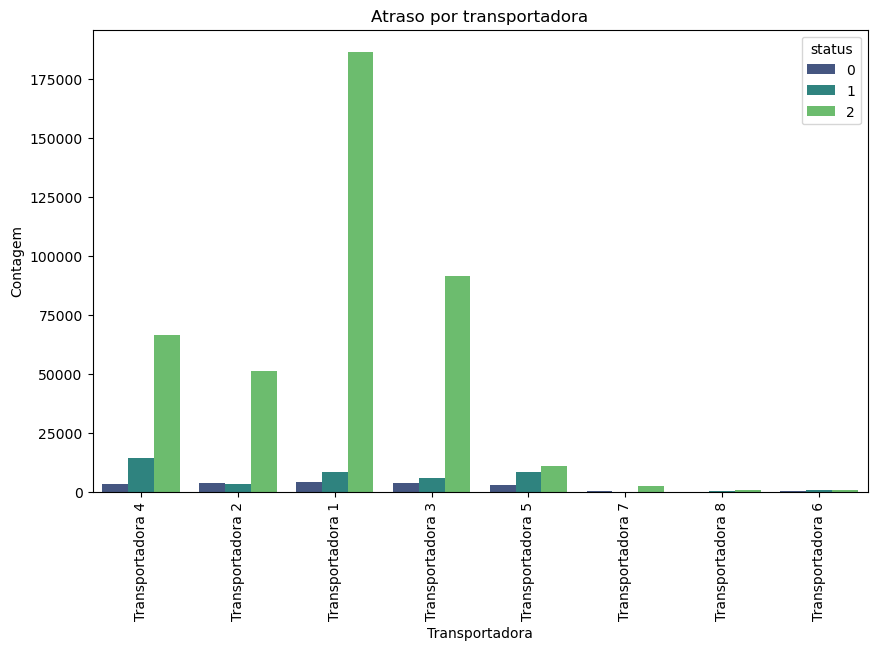

In [66]:
df['status'] = df['status'].astype('category')
plt.figure(figsize=(10, 6))
sns.countplot(x='grp_transportadora', hue='status', data=df, palette='viridis')
plt.title('Atraso por transportadora')
plt.xlabel('Transportadora')
plt.ylabel('Contagem')
plt.xticks(rotation=90)
plt.show()

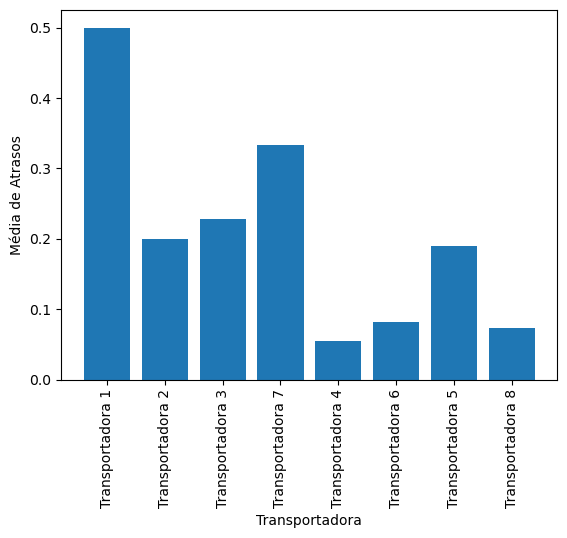

In [67]:
plt.bar(df_merge['grp_transportadora'], df_merge['percentual_atraso'])
plt.xticks(rotation=90)
plt.xlabel('Transportadora')
plt.ylabel('Média de Atrasos')

plt.show()

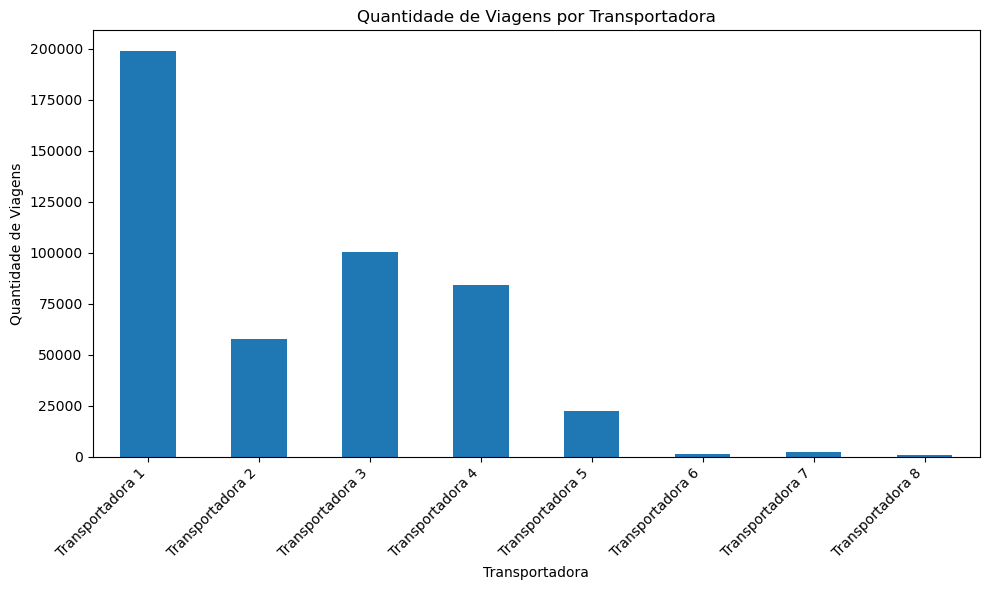

In [68]:
viagens_por_transportadora = df_merge.groupby('grp_transportadora')['viagens'].sum()

# Plotar o gráfico de barras
plt.figure(figsize=(10, 6))
viagens_por_transportadora.plot(kind='bar')
plt.title('Quantidade de Viagens por Transportadora')
plt.xlabel('Transportadora')
plt.ylabel('Quantidade de Viagens')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [69]:
viagens_por_trecho = df_merge.groupby(['grp_transportadora', 'uf_origem', 'uf'])['viagens'].sum()

In [70]:
trecho_mais_viagens_por_transportadora = viagens_por_trecho.groupby('grp_transportadora').idxmax()

In [71]:
list_transp = []
for transportadora, trecho in trecho_mais_viagens_por_transportadora.items():
    results_transp = df_merge[df_merge['grp_transportadora'] == transportadora]
    results_transp = df_merge[df_merge['uf_origem'] == trecho[1]]
    results_transp = df_merge[df_merge['uf'] == trecho[2]]
    results_transp = results_transp['viagens'].max()
    list_transp.append([transportadora, results_transp,trecho[1], trecho[2]])

In [72]:
df_por_transp = pd.DataFrame(list_transp, columns=['grp_transportadora', 'viagens','uf_origem', 'uf'])

In [73]:
df_por_transp['trecho'] = df_por_transp.uf_origem + '-' + df_por_transp.uf + '(' + df_por_transp.grp_transportadora + ')'

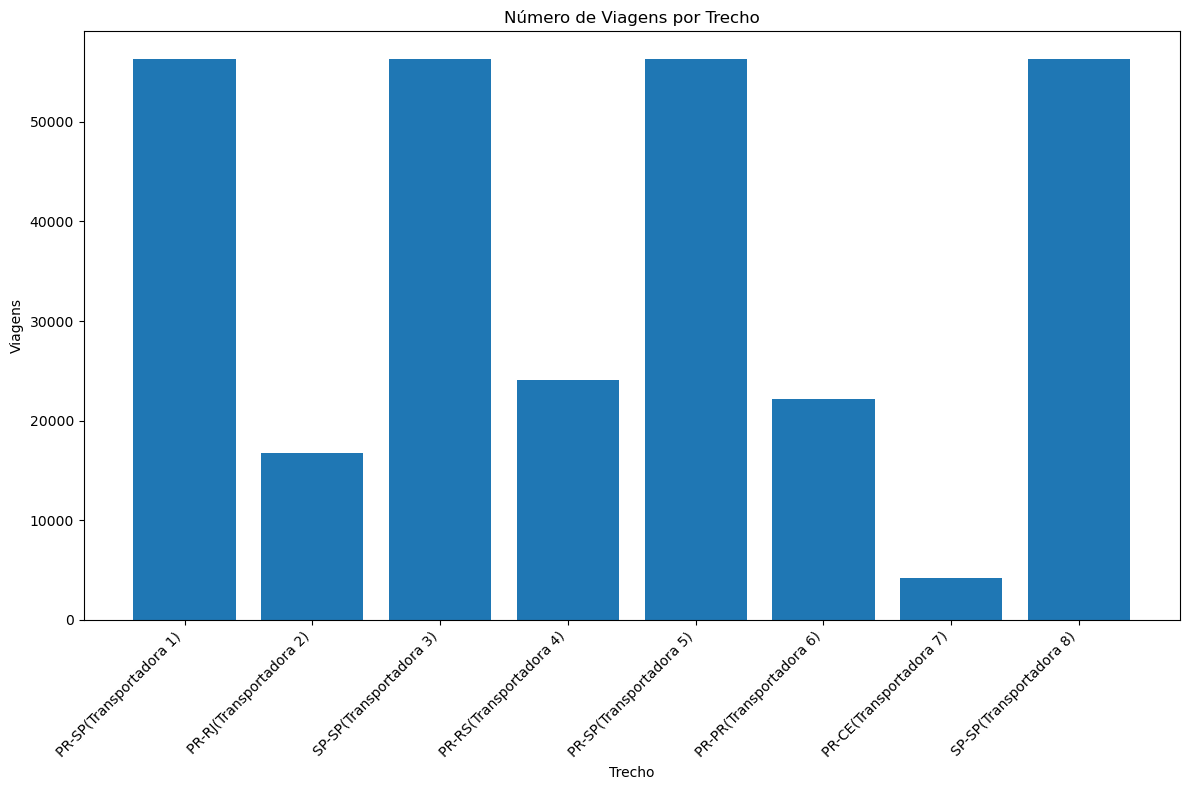

In [74]:
plt.figure(figsize=(12, 8))
plt.bar(df_por_transp.trecho, df_por_transp.viagens)


plt.xlabel('Trecho')
plt.ylabel('Viagens')
plt.title('Número de Viagens por Trecho')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

In [75]:
transp = df_merge[(df_merge['grp_transportadora'] == "Transportadora 1")]
def cor_por_intensidade_green(viagens):
    if viagens <= 0.036:
        return 'green'
    elif 0.036 >= viagens <= 0.068:
        return ''
    elif viagens > 0.073:
        return ''

def cor_por_intensidade(viagens):
    if viagens <= 0.036:
        return ''
    elif 0.036 >= viagens <= 0.068:
        return 'blue'
    elif viagens > 0.073:
        return 'red'
    
mapa = folium.Map(location=[-15.77972, -47.92972], zoom_start=4)
for index, row in transp.iterrows():
    origem = coordenadas_estados[row['uf_origem']]
    destino = coordenadas_estados[row['uf']]
    folium.PolyLine(
        locations=[origem, destino],
        color=cor_por_intensidade_green(row['percentual_atraso']),
        weight=5,  
        opacity=0.3
    ).add_to(mapa)
    
for index, row in transp.iterrows():
    origem = coordenadas_estados[row['uf_origem']]
    destino = coordenadas_estados[row['uf']]
    folium.PolyLine(
        locations=[origem, destino],
        color=cor_por_intensidade(row['percentual_atraso']),
        weight=5,  
        opacity=0.9
    ).add_to(mapa)
    
mapa